In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tools import *

import os
import warnings
import gc

In [2]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit, cross_val_score

In [3]:
df_orig = pd.read_csv('../input/train.csv', index_col='id');
df_structures = pd.read_csv('../input/structures.csv');
df_scc = pd.read_csv('../input/scalar_coupling_contributions.csv');

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
join_keys = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type']
df_orig = pd.merge(df_orig, df_scc, how = 'left', left_on= join_keys, right_on= join_keys)
del df_scc

In [5]:
df_orig = reduce_mem_usage(df_orig)
df_structures = reduce_mem_usage(df_structures)
df = get_portion(df_orig, r=0.1)
gc.collect()

Mem. usage decreased to 159.92 Mb (55.0% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)


28

In [6]:
# Feature Engineering
df = get_dists(df, df_structures)
df = atoms_per_molecule(df)

In [9]:
df.shape

(469534, 21)

In [35]:
df.head()

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso,atom_0,...,y_0,z_0,atom_1,x_1,y_1,z_1,dist,n_C,n_H,n_N
0,dsgdb9nsd_000034,4,1,2JHC,-0.239990,-0.413330,0.040009,0.719727,-0.585938,H,...,1.769531,0.004177,C,0.012932,0.034424,0.002092,1.935547,2,2,1
1,dsgdb9nsd_000034,4,2,3JHC,10.234375,10.265625,0.097839,0.577637,-0.707031,H,...,1.769531,0.004177,C,-1.357422,-0.488770,0.012398,3.171875,2,2,1
2,dsgdb9nsd_000034,4,5,3JHH,1.627930,1.630859,0.037506,1.069336,-1.111328,H,...,1.769531,0.004177,H,0.517090,-0.363281,-0.892090,2.341797,2,2,1
3,dsgdb9nsd_000034,4,6,3JHH,1.649414,1.650391,0.038239,1.066406,-1.105469,H,...,1.769531,0.004177,H,0.533691,-0.372803,0.882324,2.339844,2,2,1
4,dsgdb9nsd_000034,5,1,1JHC,96.437500,95.375000,0.092590,0.139038,0.873535,H,...,-0.363281,-0.892090,C,0.012932,0.034424,0.002092,1.100586,2,2,1


In [41]:
feats = [
#     'molecule_name',
#     'atom_index_0',
#     'atom_index_1',
    'type',
    'scalar_coupling_constant',
    'fc',
    'sd',
    'pso',
    'dso',
#     'atom_0',
#     'x_0',
#     'y_0',
#     'z_0',
#     'atom_1',
#     'x_1',
#     'y_1',
#     'z_1',
    'dist', 
#     'n_C',
#     'n_H',
#     'n_N'
]

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


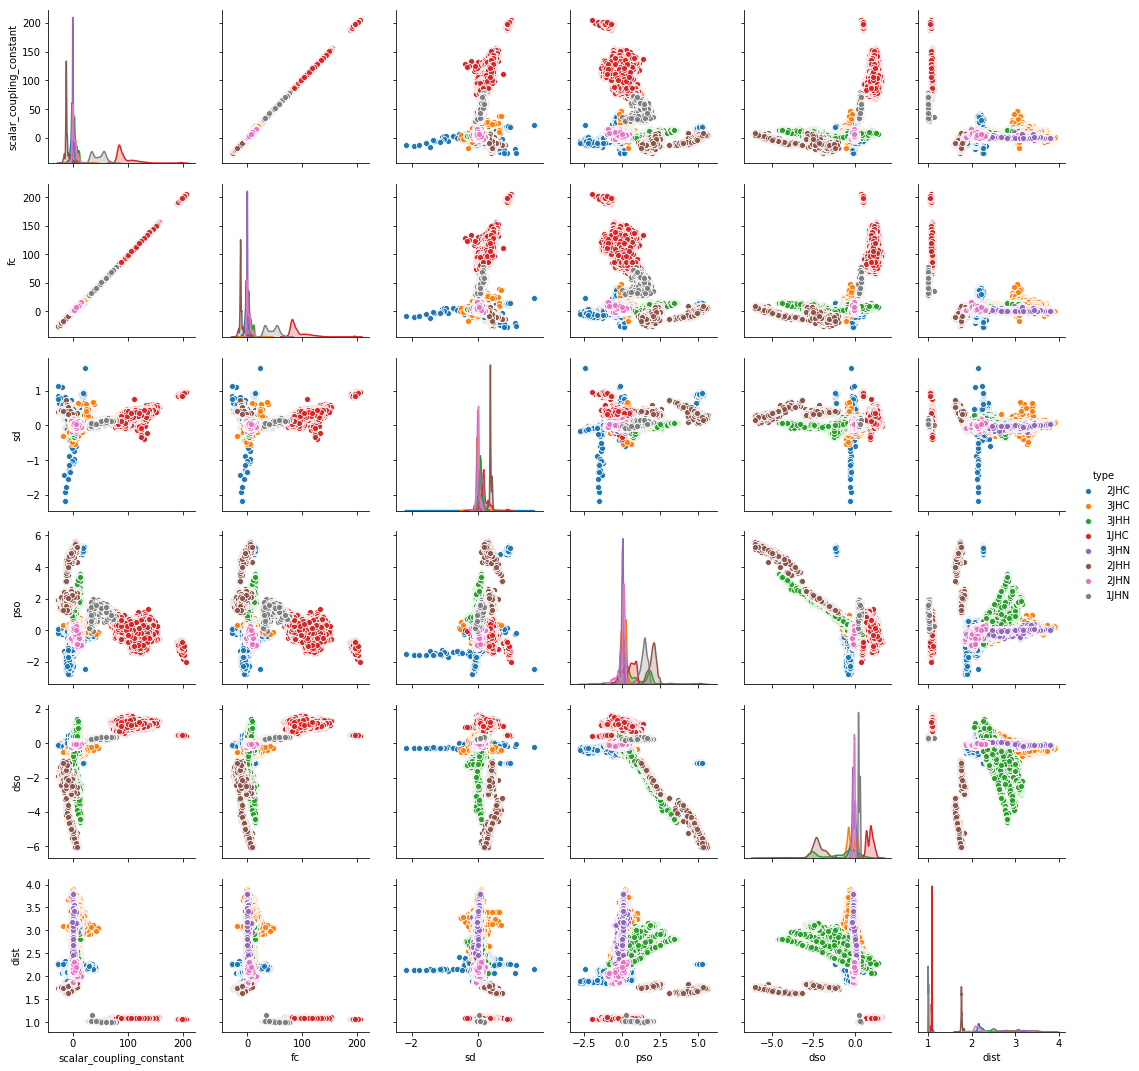

In [43]:
sns.pairplot(df[feats], hue='type')

In [44]:
feats = [
#     'molecule_name',
#     'atom_index_0',
#     'atom_index_1',
    'type',
#     'scalar_coupling_constant',
    'fc',
    'sd',
    'pso',
    'dso',
#     'atom_0',
#     'x_0',
#     'y_0',
#     'z_0',
#     'atom_1',
#     'x_1',
#     'y_1',
#     'z_1',
    'dist', 
    'n_C',
    'n_H',
    'n_N'
]

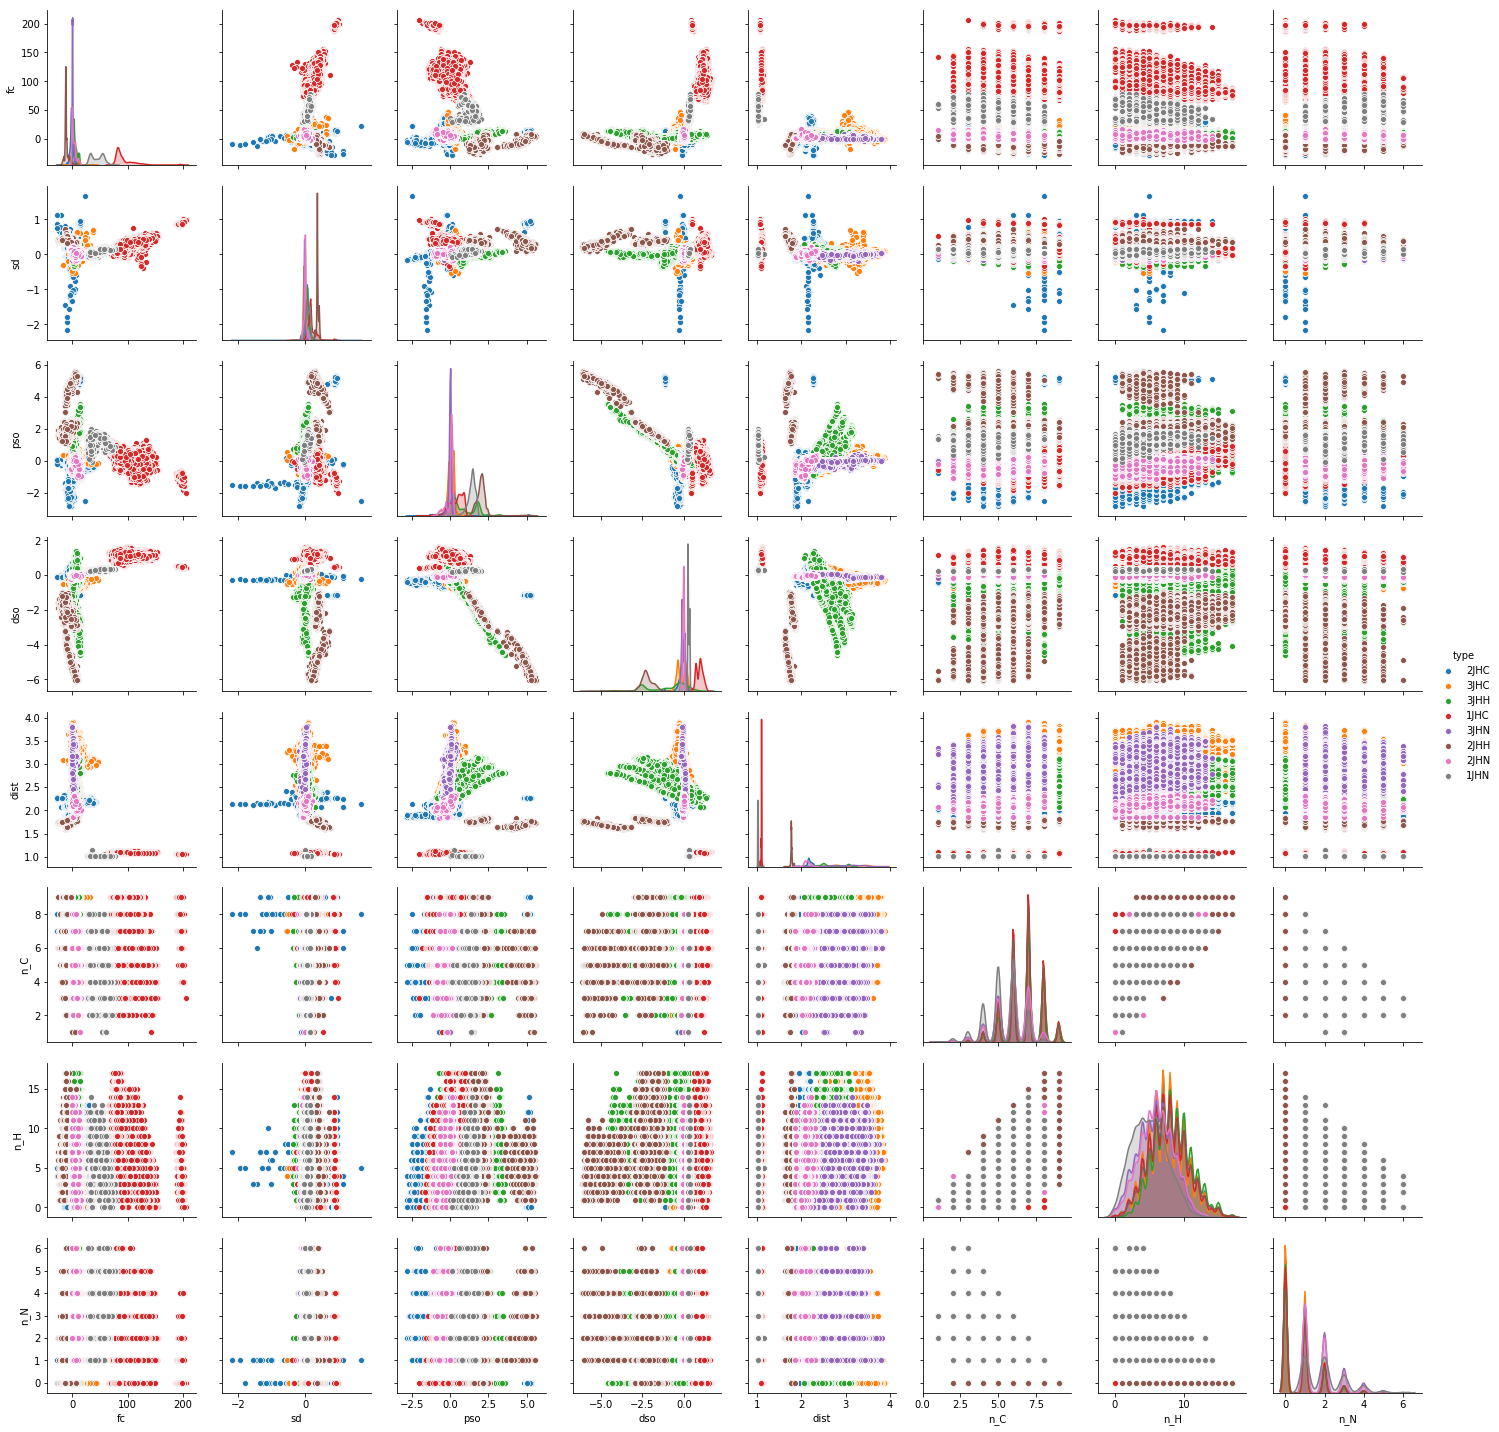

In [45]:
sns.pairplot(df[feats], hue='type')

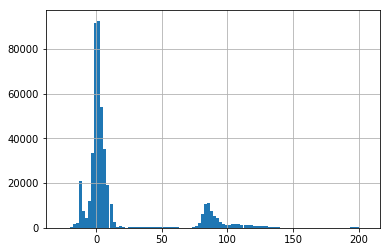

In [25]:
df.scalar_coupling_constant.hist(bins=100)

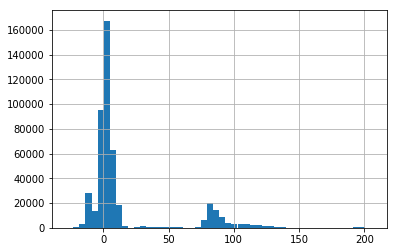

In [24]:
df.fc.hist(bins=100)

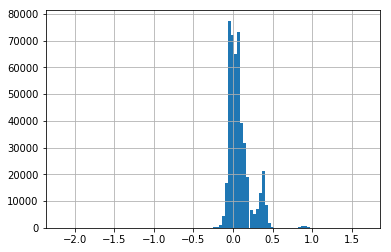

In [26]:
df.sd.hist(bins=100)

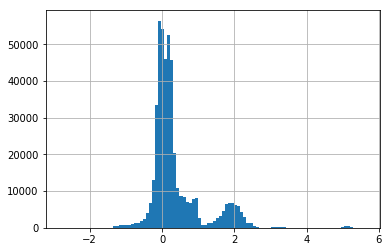

In [28]:
df.pso.hist(bins=100)

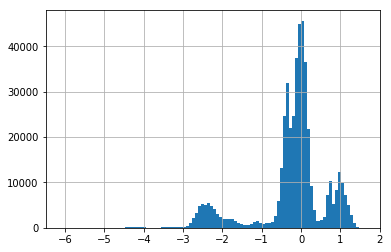

In [29]:
df.dso.hist(bins=100)

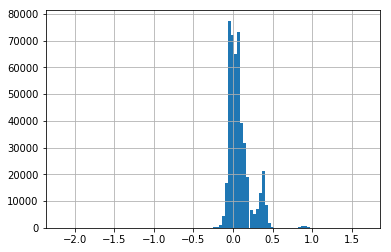

In [26]:
df.sd.hist(bins=100)

# Prediccting Fermi Constant

In [7]:
feats = [
#     'molecule_name',
#     'atom_index_0',
#     'atom_index_1',
    'type',
#     'scalar_coupling_constant',
#     'fc',
#     'sd',
#     'pso',
#     'dso',
#     'atom_0',
    'x_0',
    'y_0',
    'z_0',
    'atom_1',
    'x_1',
    'y_1',
    'z_1',
    'dist', 
    'n_C',
    'n_H',
    'n_N'
]
target = ['fc']

In [8]:
rf = RandomForestRegressor(n_jobs=-1)
gss = GroupShuffleSplit(n_splits=3)
train_idxs, test_idxs = next(gss.split(df[feats], df[target], groups=df['molecule_name']))
Xtrain, Xtest, ytrain, ytest = df.iloc[train_idxs], df.iloc[test_idxs], df.iloc[train_idxs], df.iloc[test_idxs]

In [16]:
def atoms_per_molecule(df):
    for atom in df['atom_1'].unique():
        qry = df.query(f'atom_1 == "{atom}"')
        counts = qry.groupby('molecule_name')['atom_index_1'].nunique().to_dict()
        df['n_' + atom] = df['molecule_name'].apply(lambda x: counts.get(x, 0))
    return df

In [10]:
categoricals = ['type', 'atom_1']
Xtrain = featurize(Xtrain, df_structures, categoricals)
feats = list(set(all_feats) - set(categoricals))
gc.collect()

AttributeError: 'DataFrame' object has no attribute 'unique'

In [ ]:
rf.fit(Xtrain[feats], ytrain)